<a href="https://colab.research.google.com/github/LCaravaggio/AnalisisPredictivo/blob/master/Kaggle/2023Q2/Un_primer_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df_train=pd.read_csv('dataset/origen.csv')

In [2]:
df_train.columns

Index(['Unnamed: 0', 'averageRating', 'numVotes', 'titleType', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres_x', 'directors',
       'writers', 'seasonNumber', 'episodeNumber', 'ordering', 'language',
       'attributes', 'isOriginalTitle', 'adult', 'budget', 'genres_y',
       'original_language', 'popularity', 'production_companies',
       'production_countries', 'revenue', 'runtime', 'status', 'tagline',
       'video'],
      dtype='object')

In [3]:
df_val=pd.read_csv('dataset/testear.csv')

In [4]:
df_train.shape

(977541, 29)

In [5]:
df_val.shape

(244386, 28)

In [13]:
y=df_train.averageRating
vars=['startYear', 'runtimeMinutes',"numVotes","isAdult","endYear"]
X=df_train[vars]
X_pred=df_val[vars]

from sklearn.preprocessing import OneHotEncoder


encoder = OneHotEncoder()


title = encoder.fit_transform(df_train[['titleType']])
title_df = pd.DataFrame(title.toarray(), columns=encoder.get_feature_names_out(['titleType']))
#split by genres
genres = df_train.genres_x.str.get_dummies(sep=',')
genres = genres.reindex(sorted(genres.columns), axis=1)


title_df = pd.concat([title_df, genres], axis=1)

X = pd.concat([X, title_df], axis=1)

title = encoder.fit_transform(df_val[['titleType']])
title_df = pd.DataFrame(title.toarray(), columns=encoder.get_feature_names_out(['titleType']))
genres = df_val.genres_x.str.get_dummies(sep=',')
#sort the genres columns alphabetically
genres = genres.reindex(sorted(genres.columns), axis=1)
# Split the genres_x column by commas and expand into separate columns

# Iterate over the columns in genres and add missing columns to X_pred
""" for col in X.columns:
    if col not in genres.columns:
        genres[col] = 0 """

# Reorder the columns to match the order in X
#genres = genres[X_pred.columns]

# Concatenate the new genres DataFrame with X_pred
title_df = pd.concat([title_df, genres], axis=1)
X_pred = pd.concat([X_pred, title_df], axis=1)


del title_df, genres, title, encoder



In [19]:
from sklearn.linear_model import LinearRegression
from lineartree import LinearForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


regr = LinearForestRegressor(base_estimator=LinearRegression(), max_features=0.5,n_estimators=75) # type: ignore
print("Training a LinearForestRegressor with {} estimators".format(regr.n_estimators))
regr.fit(X_train, y_train)
print("Finished training the LinearForestRegressor")
score = regr.score(X_test, y_test)
print("R^2 score on testing data: {:.4f}".format(score)) 
# 0.7 - 0.3819 | 0.6 - 0.3845 | 0.5 - 0.3867 | 0.4 - 0.3862
# 50 - 0.3862 | 60 - 0.3875 | 70 - 0.3886 | 75 - 0.3888 | 80 - 0.3886



Training a LinearForestRegressor with 75 estimators
Finished training the LinearForestRegressor
R^2 score on testing data: 0.3907


In [20]:
from concurrent.futures import ThreadPoolExecutor
from sklearn.linear_model import LinearRegression
from lineartree import LinearForestRegressor
from sklearn.model_selection import train_test_split

# Define the number of threads to use
num_threads = 4

# Define the random states to use
random_states = [12, 21, 36, 42]

# Define the training and testing data


# Define a function to train the model and return the R^2 score
def train_model(random_state):
    # Create a LinearForestRegressor with the specified random state
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    regr = LinearForestRegressor(base_estimator=LinearRegression(), max_features=0.5, n_estimators=75)
    print("Training a LinearForestRegressor with {} estimators and random state {}".format(regr.n_estimators, random_state))
    regr.fit(X_train, y_train)
    print("Finished training the LinearForestRegressor with random state {}".format(random_state))
    score = regr.score(X_test, y_test)
    print("R^2 score on testing data with random state {}: {:.4f}".format(random_state, score))
    return score

# Use a ThreadPoolExecutor to run the function on multiple threads
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    # Submit the function to the executor for each random state
    futures = [executor.submit(train_model, random_state) for random_state in random_states]

    # Wait for all the futures to complete and get the results
    results = [future.result() for future in futures]

# Print the average R^2 score across all the random states
print("Average R^2 score across all random states: {:.4f}".format(sum(results) / len(results)))


Training a LinearForestRegressor with 75 estimators and random state 42
Training a LinearForestRegressor with 75 estimators and random state 12
Training a LinearForestRegressor with 75 estimators and random state 21
Training a LinearForestRegressor with 75 estimators and random state 36
Finished training the LinearForestRegressor with random state 42
Finished training the LinearForestRegressor with random state 36
Finished training the LinearForestRegressor with random state 21
R^2 score on testing data with random state 42: 0.3902
R^2 score on testing data with random state 36: 0.3871
R^2 score on testing data with random state 21: 0.3916
Finished training the LinearForestRegressor with random state 12
R^2 score on testing data with random state 12: 0.3889
Average R^2 score across all random states: 0.3895
0.38892812354330375
0.3915679047569466
0.3871112090964901
0.3902252679299725


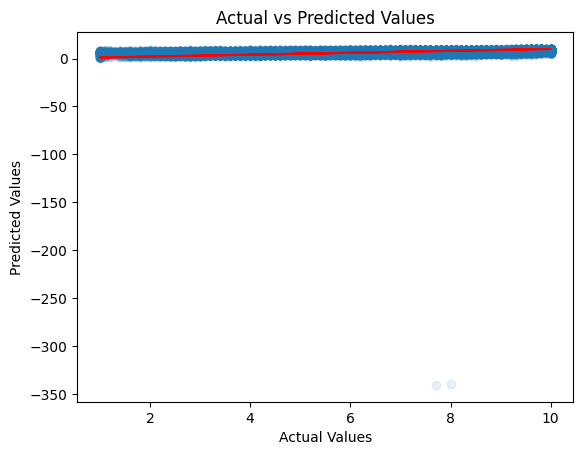

In [17]:
import matplotlib.pyplot as plt

# Assume regr is your trained LinearForestRegressor
predictions = regr.predict(X_test)

# Create a scatter plot of predicted vs actual values with transparency
plt.scatter(y_test, predictions, alpha=0.1)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

# Plot a line for perfect correlation. This serves as a reference line.
plt.plot(y, y, 'r')

plt.show()

In [ ]:
Yest = regr.predict(X_pred)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume regr is your trained LinearForestRegressor
importances = regr.feature_importances_

# Convert to pandas Series for easier plotting
importances = pd.Series(importances, index=X.columns)

# Sort importances
importances = importances.sort_values()

# Plot
importances.plot(kind='barh')
plt.title('Feature Importances')
plt.show()


In [ ]:
from lineartree import RandomForestRegressor
regr = RandomForestRegressor( max_features=0.5,n_estimators=75) # type: ignore
print("Training a random forest with n estimators")
regr.fit(X_train, y_train)
print("Finished training the LinearForestRegressor")
score = regr.score(X_test, y_test)
print("R^2 score on testing data: {:.4f}".format(score))


In [ ]:
salida = pd.DataFrame(data={"averageRating": Yest})
salida.index = df_val.index
salida.to_csv("pred3.csv", sep=',',index=True,  index_label='Id')